In [33]:
import re
import numpy as np
import queue
import string
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn.cluster import AgglomerativeClustering
import warnings

In [2]:
def preprocess(text: str) -> str:
    return "".join(["".join([i.lower() for i in list(j) if i.isalpha()]+[" "])for j in text.split()])

In [3]:
with open("lines.txt","r") as file:
    lines = file.readlines()

In [4]:
def stopwords(texts:list[list[string]]):
    word_dict = dict()
    for text in texts:
        for word in text:
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1
    Q = queue.PriorityQueue()
    for word in word_dict.keys():
        Q.put((-word_dict[word],word))
    n = len(texts)//100 #stopwords to u mnie 1% najczęściej powtarzających się słów
    return {Q.get()[1] for i in range(n)}

In [49]:
def texts_to_vec(docs: list[str],process:bool) -> list[list[int]]:
    n = len(docs)
    dicts = [dict() for i in range(n)]
    prep = [preprocess(i).split() for i in docs]
    if process:
        swords = stopwords(prep)
    for i in range(n):
        for word in prep[i]:
            if word in dicts[i]:
                dicts[i][word] += 1
            else:
                dicts[i][word] = 1
    common=set()
    for i in range(n):
        common = common.union(set(dicts[i].keys()))
    vectors = [[] for i in range(n)]
    for word in common:
        if (process and word not in swords) or not process:
            for i in range(n):
                if word in dicts[i]:
                    vectors[i].append(dicts[i][word])
                else:
                    vectors[i].append(0)
    return np.array([np.array(v) for v in vectors])

In [37]:
def cosine_matrix(texts: list[str],process:bool):
    vecs = texts_to_vec(texts,process)
    lens = np.nan_to_num(1/np.sqrt(np.sum(vecs**2,axis = 1)),nan=0.0,posinf=0.0,neginf=0.0)
    vecs = (vecs.T * lens).T
    n= len(texts)
    matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            sim = 1-vecs[i]@vecs[j]
            matrix[i,j] = sim
            matrix[j,i] = sim
    return matrix

In [7]:
def LCS(str_a,str_b):
    m,n = len(str_a)+1,len(str_b)+1
    matrix = np.zeros((m,n))
    for i in range(1,m):
        for j in range(1,n):
            if str_a[i-1] == str_b[j-1]:
                matrix[i,j] = matrix[i-1,j-1]+1
            else:
                matrix[i,j] = max(matrix[i-1,j-1],matrix[i,j-1],matrix[i-1,j])
    return matrix[-1,-1]

In [56]:
def LCS_matrix(texts: list[str],process:bool):
    n= len(texts)
    matrix = np.ones((n,n))
    prep = [preprocess(text).split() for text in texts]
    dictionary = dict()
    i = 0
    for text in prep:
        for word in text:
            if not word in dictionary:
                dictionary[word]=i
                i+=1
    if process:
        swords = stopwords([p for p in prep])
        prep = [[word for word in p  if word not in swords] for p in prep]
    prep = [np.array([dictionary[word] for word in p],dtype=np.int32) for p in prep]
    for i in range(n):
        for j in range(i):
            dist = -LCS(prep[i],prep[j])
            matrix[i,j] = dist
            matrix[j,i] = dist
    return matrix

In [9]:
def dice_matrix(texts: list[str],process:bool):
    n= len(texts)
    matrix = np.ones((n,n))
    prep = [preprocess(text).split() for text in texts]
    dictionary = dict()
    i = 0
    for text in prep:
        for word in text:
            if not word in dictionary:
                dictionary[word]=i
                i+=1
    if process:
        swords = stopwords([p for p in prep])
        prep = [[word for word in p  if word not in swords] for p in prep]
    prep = [[dictionary[word] for word in p] for p in prep]
    for i in range(n):
        p_a = set(prep[i])
        for j in range(i):
            p_b = set(prep[j])
            dice = 2*len(p_a.intersection(p_b))/max(len(p_a)+len(p_b),1)
            matrix[i,j] = dice
            matrix[j,i] = dice
    return matrix

In [15]:
def DB(clusters):
    #Indeks Daviesa -Bouldina
    n = len(clusters)
    centers = [np.sum(cluster,axis =0)/len(cluster) for cluster in clusters]
    S_arr = [np.sqrt(np.sum((clusters[i]-centers[i])**2)/len(clusters[i])) for i in range(n)]
    M_arr = [[np.sqrt(np.sum((centers[i]-centers[j])**2)) for i in range(n)]for j in range(n)]
    D =0
    for i in range(n):
        best_R = 0
        for j in range(n):
            R = np.nan_to_num((S_arr[i]+S_arr[j])/M_arr[i][j],nan=0.0,posinf=0.0,neginf=0.0)
            if i!=j and R > best_R:
                best_R = R
        D += best_R
    return D/n

In [11]:
def clusterize(data, dist_matrix):
    ag = AgglomerativeClustering(n_clusters=13,affinity ='precomputed',linkage='single')
    ag.fit(dist_matrix)
    labels = ag.labels_
    clusters = [[]for i in range(ag.n_clusters)]
    for i,label in enumerate(labels):
        clusters[label].append(data[i,:])
    return clusters

In [61]:
with warnings.catch_warnings():
    #Pozbywam się ostrzeżeń wynikających z dzielenia przez 0
    #takie dzielenia zastępuję odpowiednimi liczbami
    warnings.simplefilter("ignore")
    metrics =[cosine_matrix,LCS_matrix,dice_matrix]
    DB_results= [[],[]]
    for i,m in enumerate(metrics):
        for process in [True,False]:
            vecs = texts_to_vec(lines,process)
            dist_matrix = m(lines,process)
            clusters = clusterize(vecs,dist_matrix)
            db = DB(clusters)
            DB_results[int(process)].append(db)

In [62]:
DB_results

[[1.546138268884126, 1.6607684272802827, 1.0636894535019699],
 [3.861303802757975, 3.861303802757975, 0.9957502556334403]]

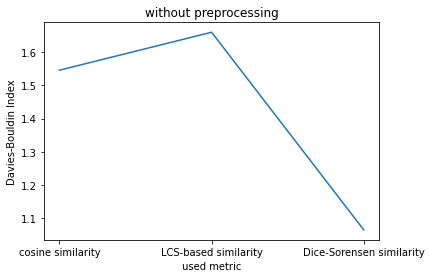

In [69]:
plt.title("without preprocessing")
plt.plot(["cosine similarity","LCS-based similarity","Dice-Sorensen similarity"],DB_results[0])
plt.ylabel("Davies-Bouldin Index")
plt.xlabel("used metric")
plt.show()

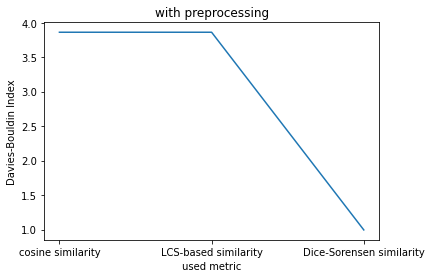

In [70]:
plt.title("with preprocessing")
plt.plot(["cosine similarity","LCS-based similarity","Dice-Sorensen similarity"],DB_results[1])
plt.ylabel("Davies-Bouldin Index")
plt.xlabel("used metric")
plt.show()

# Wnioski
Okazuje się że najlepsze wyniki klasteryzacji daje metryka oparta na podobieństwie Dice'a-Sørensena
Metryka ta dawała nieco lepsze wyniki, gdy przeprowadziełem dodatkowy preprocessing tekstów. W przypadku pozostałych metryk, wyniki okazały się gorsze po preprocessingu.

Innym sposobem na podniesienie jakości klasteryzacji mogłoby być obliczenie Inverse word frequency i pomnożenie wektorów słów (kolumn macierzy tekstów) przez odpowiadające im logarytmy odwróconej częstości wystąpień danych słów.